In [1]:
import numpy as np
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
import astropy.units as u
from galpy.potential import MWPotential2014, vcirc

#  Functions for sampling

In [2]:
def sample_exponential_disk(N, lR, lz, Rmax=None):
    """Sample stars from a double-exponential disk."""
    R = np.random.gamma(shape=2.0, scale=lR.value, size=N) * lR.unit
    z = np.random.choice([-1, 1], size=N) * np.random.exponential(lz.value, size=N) * lz.unit
    phi = np.random.uniform(0, 2*np.pi, size=N) * u.rad

    if Rmax is not None:
        mask = R < Rmax
        R, z, phi = R[mask], z[mask], phi[mask]

    x = R * np.cos(phi)
    y = R * np.sin(phi)
    return x, y, z


def sample_spherical_component(N, lR, Rmax=None):
    """Sample stars from a spherical exponential component (ρ ∝ e^{-R/lR})."""
    R = np.random.gamma(shape=3.0, scale=lR.value, size=N) * lR.unit
    if Rmax is not None:
        R = R[R < Rmax]

    phi = np.random.uniform(0, 2*np.pi, len(R))
    cos_theta = np.random.uniform(-1, 1, len(R))
    sin_theta = np.sqrt(1 - cos_theta**2)

    x = R * sin_theta * np.cos(phi)
    y = R * sin_theta * np.sin(phi)
    z = R * cos_theta
    return x, y, z

#  Parameters for each component

In [15]:
params = {
    "thin":  {"lR": 3.5*u.kpc, "lz": 0.3*u.kpc, "N": 80000, "color": "green"},
    "thick": {"lR": 2.9*u.kpc, "lz": 1.0*u.kpc, "N": 80000, "color": "lightblue"},
    "bulge": {"lR": 1.8*u.kpc, "N": 40000, "color": "red"},
    "halo":  {"lR": 15.0*u.kpc,"N": 40000, "color": "yellow"}
}

alpha_halo = 0.1
alpha_thic = 0.2
alpha_thin = 0.2
alpha_bulge = 0.05

Rmax_thin  = 50 * u.kpc
Rmax_thick = 50 * u.kpc
Rmax_bulge = 50 * u.kpc
Rmax_halo  = 50 * u.kpc


#  Generate all components
x_thin,  y_thin,  z_thin  = sample_exponential_disk(params["thin"]["N"],  params["thin"]["lR"],  params["thin"]["lz"],  Rmax=Rmax_thin)
x_thick, y_thick, z_thick = sample_exponential_disk(params["thick"]["N"], params["thick"]["lR"], params["thick"]["lz"], Rmax=Rmax_thick)
x_bulge, y_bulge, z_bulge = sample_spherical_component(params["bulge"]["N"], params["bulge"]["lR"], Rmax=Rmax_bulge)
x_halo,  y_halo,  z_halo  = sample_spherical_component(params["halo"]["N"],  params["halo"]["lR"],  Rmax=Rmax_halo)

#  Plots

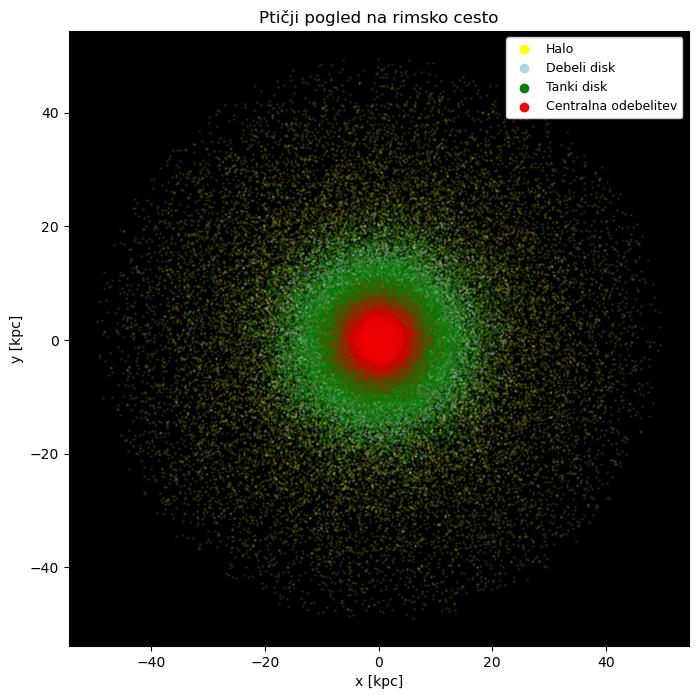

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)



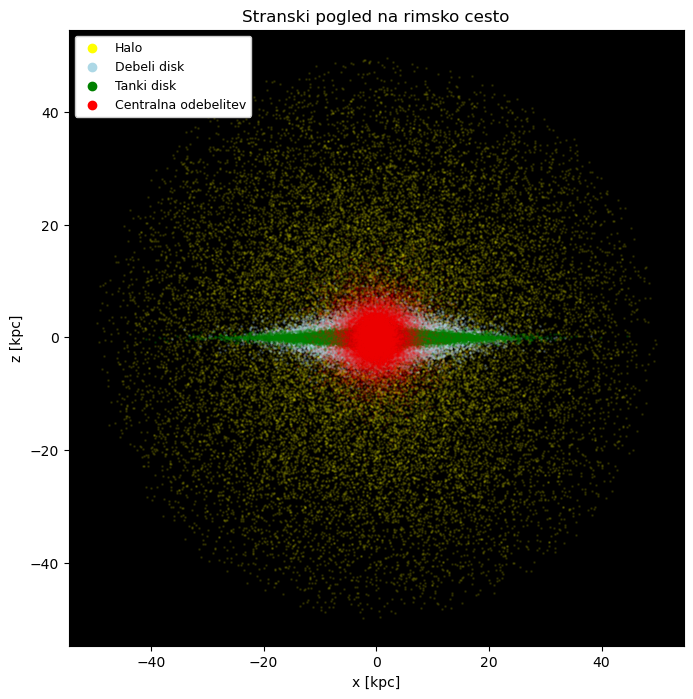

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(x_halo.value,  y_halo.value,  s=1, alpha=alpha_halo, color=params["halo"]["color"])
plt.scatter([], [], color=params["halo"]["color"], label='Halo', alpha=1)
plt.scatter(x_thick.value, y_thick.value, s=1, alpha=alpha_thic, color=params["thick"]["color"])
plt.scatter([], [], color=params["thick"]["color"], alpha=1, label="Debeli disk")
plt.scatter(x_thin.value,  y_thin.value,  s=1, alpha=alpha_thin, color=params["thin"]["color"])
plt.scatter([], [], color=params["thin"]["color"], alpha=1, label="Tanki disk")
plt.scatter(x_bulge.value, y_bulge.value, s=1, alpha=alpha_bulge,  color=params["bulge"]["color"])
plt.scatter([], [], color=params["bulge"]["color"], alpha=1, label="Centralna odebelitev")
plt.xlabel("x [kpc]"); plt.ylabel("y [kpc]")
plt.title("Ptičji pogled na rimsko cesto")
plt.legend(fontsize=9, framealpha = 1)
plt.gca().set_aspect("equal", "box")
plt.gca().set_facecolor('black')
plt.show()


# Side view (x–z plane)
plt.figure(figsize=(8,8))
plt.scatter(x_halo.value,  z_halo.value,  s=1, alpha=alpha_halo, color=params["halo"]["color"])
plt.scatter([], [], color=params["halo"]["color"], label='Halo', alpha=1)
plt.scatter(x_thick.value, z_thick.value, s=1, alpha=alpha_thic, color=params["thick"]["color"])
plt.scatter([], [], color=params["thick"]["color"], alpha=1, label="Debeli disk")
plt.scatter(x_thin.value,  z_thin.value,  s=1, alpha=alpha_thin, color=params["thin"]["color"])
plt.scatter([], [], color=params["thin"]["color"], alpha=1, label="Tanki disk")
plt.scatter(x_bulge.value, z_bulge.value, s=1, alpha=alpha_bulge,  color=params["bulge"]["color"])
plt.scatter([], [], color=params["bulge"]["color"], alpha=1, label="Centralna odebelitev")
plt.xlabel("x [kpc]"); plt.ylabel("z [kpc]")
plt.title("Stranski pogled na rimsko cesto")
plt.legend(fontsize=9, framealpha = 1)
plt.gca().set_aspect("equal", "box")
plt.gca().set_facecolor('black')
plt.show()

In [40]:
#  Parameters
# -----------------------------
ro = 8.0 * u.kpc
vo = 220.0 * u.km/u.s

# Number of stars to integrate (keep small for speed)
N_int = 20000  

# Integration time (shorter first)
t_end = 2 * u.Gyr      # total time
n_steps = 2            # number of timesteps

ts = np.linspace(0, t_end.value, n_steps) * u.Gyr

# -----------------------------
#  Select subset of stars from all components
# -----------------------------
# You can combine or test separately — here we merge thin + thick disks + bulge + halo
x_all = np.concatenate([x_thin.value, x_thick.value, x_bulge.value, x_halo.value])
y_all = np.concatenate([y_thin.value, y_thick.value, y_bulge.value, y_halo.value])
z_all = np.concatenate([z_thin.value, z_thick.value, z_bulge.value, z_halo.value])

# Randomly choose N_int stars
idx = np.random.choice(len(x_all), N_int, replace=False)

x0, y0, z0 = x_all[idx], y_all[idx], z_all[idx]

# Simple velocity model: circular + small random dispersion (20 km/s typical)
vR0 = np.random.normal(0, 20, N_int) * u.km/u.s
vT0 = np.random.normal(220, 20, N_int) * u.km/u.s
vz0 = np.random.normal(0, 20, N_int) * u.km/u.s
phi0 = np.arctan2(y0, x0) * u.rad
R0 = np.sqrt(x0**2 + y0**2) * u.kpc

# -----------------------------
#  Create Orbit objects
# -----------------------------
orbits = []
for i in range(N_int):
    o = Orbit(vxvv=[R0[i], vR0[i], vT0[i], z0[i]*u.kpc, vz0[i], phi0[i]],
              ro=ro, vo=vo)
    orbits.append(o)

# -----------------------------
#  Integrate all orbits
# -----------------------------
for o in orbits:
    o.integrate(ts, MWPotential2014)


Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ...

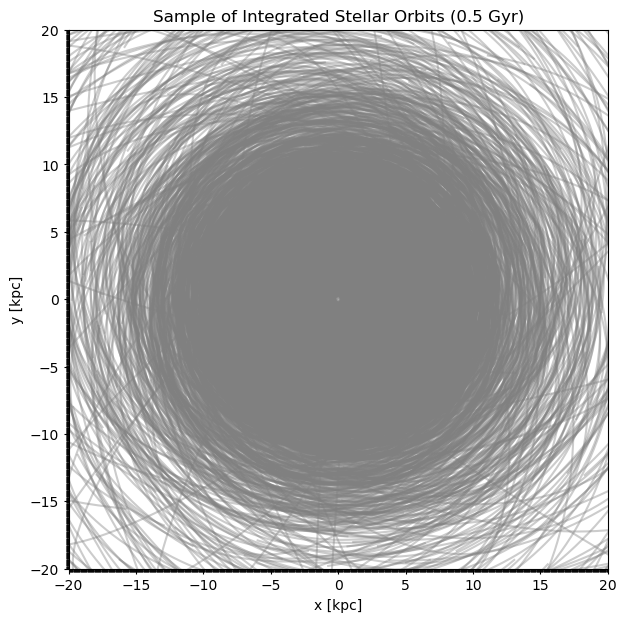

Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ..., 20.04]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1003 ticks ([-20.04, ...

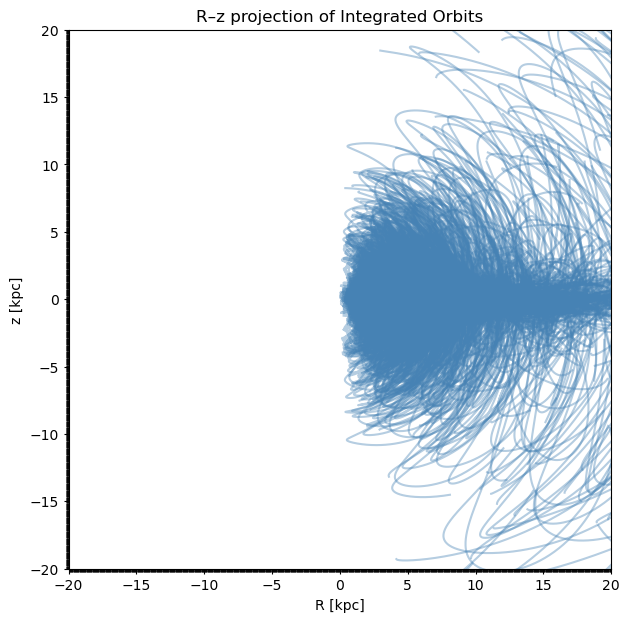

In [ ]:
# -----------------------------
#  Plot a few example orbits (just to visualize)
# -----------------------------
o.turn_physical_on()

plt.figure(figsize=(7,7))
for i in range(len(orbits)):  # only a few for clarity
    orbits[i].plot(d1='x', d2='y', overplot=True, color='gray', alpha=0.4, ro=8., vo=220.)
plt.title("Sample of Integrated Stellar Orbits (0.5 Gyr)")
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.gca().set_aspect("equal", "box")
plt.xlim(-20,20)
plt.ylim(-20, 20)
plt.show()

# -----------------------------
#  Check vertical structure evolution (R–z snapshot)
# -----------------------------
plt.figure(figsize=(7,7))
for i in range(len(orbits)):
    orbits[i].plot(d1='R', d2='z', overplot=True, color='steelblue', alpha=0.4, ro=8., vo=220.)
plt.title("R–z projection of Integrated Orbits")
plt.xlabel("R [kpc]")
plt.ylabel("z [kpc]")
plt.xlim(-20,20)
plt.ylim(-20, 20)
plt.show()

⟨R⟩ initial =  63.13 → final =  79.75 kpc
⟨|z|⟩ initial = 21.189 → final = 19.115 kpc
σ_R:  62.68 → 100.44 kpc
σ_z: 47.080 → 55.789 kpc
⟨|ΔE/E|⟩ = 0.000e+00


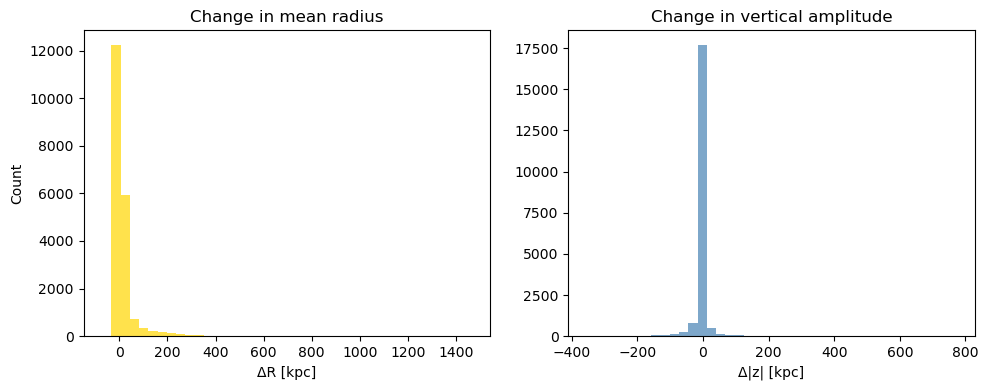

In [41]:
def orbit_stability_test(orbits, ts, pot, ro=8*u.kpc, vo=220*u.km/u.s):
    """Compute diagnostic parameters for orbit stability (unit-safe and robust)."""
    Rs_initial, Rs_final = [], []
    zs_initial, zs_final = [], []
    E_initial, E_final = [], []

    for o in orbits:
        try:
            o.turn_physical_on(ro=ro, vo=vo)
        except Exception:
            pass

        # Radii and heights
        R_vals = o.R(ts)
        z_vals = o.z(ts)

        # Safe conversion to floats in kpc
        if hasattr(R_vals[0], "to"):
            R_vals = R_vals.to(u.kpc).value
            z_vals = z_vals.to(u.kpc).value
        else:
            R_vals = np.asarray(R_vals) * ro.value
            z_vals = np.asarray(z_vals) * ro.value

        if len(R_vals) < 2:  # skip weird degenerate orbits
            continue

        Rs_initial.append(R_vals[0])
        Rs_final.append(R_vals[-1])
        zs_initial.append(abs(z_vals[0]))
        zs_final.append(abs(z_vals[-1]))

        # Orbital energy (handle both scalar and array outputs)
        try:
            E = o.E(pot=pot, t=ts)
        except Exception:
            E = o.E(pot=pot)
        E = np.atleast_1d(np.array(E, dtype=float))
        E_initial.append(E[0])
        E_final.append(E[-1])

    # Convert to numpy arrays
    Rs_initial, Rs_final = np.array(Rs_initial), np.array(Rs_final)
    zs_initial, zs_final = np.array(zs_initial), np.array(zs_final)
    E_initial, E_final = np.array(E_initial), np.array(E_final)

    # Compute statistics
    mean_R_i, mean_R_f = np.mean(Rs_initial), np.mean(Rs_final)
    mean_z_i, mean_z_f = np.mean(zs_initial), np.mean(zs_final)
    sigma_R_i, sigma_R_f = np.std(Rs_initial), np.std(Rs_final)
    sigma_z_i, sigma_z_f = np.std(zs_initial), np.std(zs_final)

    # Avoid division by zero in energy normalization
    valid_E = (np.abs(E_initial) > 1e-12)
    dE = np.mean(np.abs((E_final[valid_E] - E_initial[valid_E]) / E_initial[valid_E]))

    # Print results
    print(f"⟨R⟩ initial = {mean_R_i:6.2f} → final = {mean_R_f:6.2f} kpc")
    print(f"⟨|z|⟩ initial = {mean_z_i:6.3f} → final = {mean_z_f:6.3f} kpc")
    print(f"σ_R: {sigma_R_i:6.2f} → {sigma_R_f:6.2f} kpc")
    print(f"σ_z: {sigma_z_i:6.3f} → {sigma_z_f:6.3f} kpc")
    print(f"⟨|ΔE/E|⟩ = {dE:7.3e}")

    # Histograms
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].hist(Rs_final - Rs_initial, bins=40, color='gold', alpha=0.7)
    axs[0].set_xlabel("ΔR [kpc]"); axs[0].set_ylabel("Count")
    axs[0].set_title("Change in mean radius")

    axs[1].hist(zs_final - zs_initial, bins=40, color='steelblue', alpha=0.7)
    axs[1].set_xlabel("Δ|z| [kpc]")
    axs[1].set_title("Change in vertical amplitude")

    plt.tight_layout()
    plt.show()


orbit_stability_test(orbits, ts, pot = MWPotential2014, ro=8*u.kpc, vo=220*u.km/u.s)